In [1]:
import sys
import os
# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())
# os.environ["JULIA_NUM_THREADS"] = "8" 
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"
os.environ["PYTHON_JULIACALL_THREADS"] = "auto"
os.environ["PYTHON_JULIACALL_OPTLEVEL"] = "3"
from pysr import PySRRegressor
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [64]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/credit_score/cleaned_credit_score_v2.csv")
# remove columns that are not categorical or numerical
data = data.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Payment_Behaviour'], axis=1)

In [3]:
# Generate the profiling report
profile_full = ProfileReport(data, title="Credit Score Cleaned", explorative=True)

# Get the description object
desc_full = profile_full.get_description()

# Access the correlation matrix
correlation_matrix = desc_full.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
categorical_cols = get_categorical_columns(data)
distributions = fit_distributions(data)
marginals = convert_distfit_to_marginals(distributions, data)

In [5]:
data_syn = generate_synthetic_dataset(original_data=data, correlation_matrix=correlation_matrix, categorical_columns=categorical_cols, marginals=marginals, n_rows=40000, correlation_threshold=0.1, edge_strategy="random", sampling_strategy="local-chunks")

In [6]:
# Generate the profiling report
profile_syn = ProfileReport(data_syn, title="Credit Score Cleaned SYN", explorative=True)

# Get the description object
desc_syn = profile_syn.get_description()

# Access the correlation matrix
correlation_matrix_syn = desc_syn.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn, "Real", "Synthetic")

In [32]:
from sdmetrics.reports.single_table import QualityReport

data_syn = data_syn[data.columns.to_list()]

metadata = {
    "columns": {
        "Month": {"sdtype": "categorical"},
        "Age": {"sdtype": "numerical"},
        "Occupation": {"sdtype": "categorical"},
        "Annual_Income": {"sdtype": "numerical"},
        "Monthly_Inhand_Salary": {"sdtype": "numerical"},
        "Num_Bank_Accounts": {"sdtype": "numerical"},
        "Num_Credit_Card": {"sdtype": "numerical"},
        "Interest_Rate": {"sdtype": "numerical"},
        "Num_of_Loan": {"sdtype": "numerical"},
        "Delay_from_due_date": {"sdtype": "numerical"},
        "Num_of_Delayed_Payment": {"sdtype": "numerical"},
        "Changed_Credit_Limit": {"sdtype": "numerical"},
        "Num_Credit_Inquiries": {"sdtype": "numerical"},
        "Credit_Mix": {"sdtype": "categorical"},
        "Outstanding_Debt": {"sdtype": "numerical"},
        "Credit_Utilization_Ratio": {"sdtype": "numerical"},
        "Credit_History_Age": {"sdtype": "numerical"},
        "Payment_of_Min_Amount": {"sdtype": "categorical"},
        "Total_EMI_per_month": {"sdtype": "numerical"},
        "Amount_invested_monthly": {"sdtype": "numerical"},
        "Monthly_Balance": {"sdtype": "numerical"},
    }
}

report = QualityReport()
report.generate(data, data_syn, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 21/21 [00:00<00:00, 38.07it/s]|
Column Shapes Score: 93.81%

(2/2) Evaluating Column Pair Trends: |██████████| 210/210 [00:01<00:00, 117.18it/s]|
Column Pair Trends Score: 91.69%

Overall Score (Average): 92.75%



In [34]:
data_sample = data_syn.sample(n=9600, random_state=42)
# variable assignment according to correlation structure
independents_lst = ['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts', 'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']
dependent_var = 'Interest_Rate'
X = data_sample[independents_lst].to_numpy()
y = data_sample[dependent_var].to_numpy()
data_sample = data_sample.reset_index()

In [35]:
sr_model = PySRRegressor(
        niterations=1024,  # Number of iterations to search for equations
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log", "abs", "sqrt"],
        elementwise_loss="loss(x, y) = (x - y)^2",  # Define loss function (mean squared error)
        verbosity=0,
        maxsize=50
    )
sr_model.fit(X, y)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                 x4   
	1   >>>>  0.081134                                      x2 + 8.016276   
	2         0.043164                                       x2 + log(x5)   
	3         0.011135                                sqrt(x2 * sqrt(x5))   
	4         0.046726                       x2 + (sqrt(x5) * 0.22451411)   
	5         0.020439             ((x5 * 0.0021026984) + 5.1627073) + x2   
	6         0.022467                     sqrt(x3) + sqrt(sqrt(x5 * x4))   
	7         0.033671                    sqrt(sqrt(x5 * x3) + (x2 * x4))   
	8         0.010809      sqrt((x2 * x4) + sqrt((x3 * x5) * 1.5509642))   
	9         0.011534        sqrt((sqrt(x3 * x5) + (x2 * x4)) + abs(x1))   
	10        0.001691  sqrt(((x4 * x2) + x1) + sqrt((x3 * x5) + 175.8...   
	11        0.001148  sqrt(sqrt(x3 * ((sqrt(x5) * x1) + x5)) + (x4 *...   
	12        0.002173  sqrt((x4 * x2) + sqrt((x3 * (x5 + (x1 * x1))) ...   
	13        0.007352  sqrt((abs((x1 - x0) + sqrt(x5 * x3)) + (x4 * x...   
	14        0.002191  sqrt(abs(x1 + ((sqrt(x5 * x3) + ((x4 * x2) - x...   
	15        0.000758  sqrt(abs((x1 + abs((sqrt(x5 * x3) + (x4 * x2))...   
	16        0.002525  sqrt((x1 + (x1 + abs(sqrt(x5 * x3) + (((x4 * x...   
	17        0.000459  sqrt((abs((sqrt(x5 * x3) + ((x4 * x2) - x0)) -...   
	18        0.000956  sqrt(abs(((x4 * x2) + ((x1 - x0) + (x1 - x0)))...   
	19        0.000055  sqrt(abs(((((abs(x1) - x0) + x1) - x0) + sqrt(...   
	20        0.000065  sqrt(abs((sqrt((x5 + x0) * x3) + (x2 * x4)) + ...   
	21        0.000026  sqrt(abs((((abs(x1) - x0) + (x1 - x0)) + sqrt(...   
	22        0.000095  log(abs((x4 * ((x1 * (x5 / 120.84929)) * (x3 /...   
	23        0.002183  (x2 / 2.2298377) + (-4.4039507 + (log(abs((((x...   
	24        0.001057  ((log((((x5 / (x0 + x3)) * (x1 + x4)) * ((x3 *...   
	25        0.001999  ((x2 / 2.6014178) + -4.9445176) + (log((((((x5...   
	26        0.000485  ((log(((((x4 * ((x2 + abs(x1 + -2.7649682)) * ...   
	27        0.000360  (log((x4 * (((((abs(x1 - sqrt(x3)) + x2) / (x3...   
	28        0.000258  ((x2 / 2.8074179) + -5.640796) + (log((((x5 * ...   
	29        0.000099  ((x2 / 2.7922413) + (log(((((x5 * (x3 - -1.078...   
	30        0.000340  ((x2 / 3.4530118) + (log(((((x5 * (x3 / 95.679...   
	31        0.000347  ((log(abs((((x5 * (x3 / 59.20652)) / (x0 + x3)...   
	32        0.000338  (x2 / 2.7685285) + ((log(((x3 - -2.8582914) * ...   
	33        0.000569  (x2 / 2.2989013) + ((x5 * 0.0005524428) + log(...   
	34        0.000245  (x2 / 2.2989013) + ((x5 * 0.0005524428) + log(...   
	35        0.001375  (log(abs((x1 - 1.3597175) * ((sin((x3 * ((x3 *...   
	36        0.000227  (log(abs((x1 - 1.3597175) * ((x4 * x4) * (sin(...   
	37        0.001486  (x2 / 2.3180234) + ((x5 * 0.00050198537) + log...   
	38        0.000668  log(abs(sin(((sin(x3 / -9.603198) * (x3 / x0))...   
	39        0.000129  (((x5 * 0.0011207063) + x2) / 2.7485266) + log...   
	40        0.000083  ((x5 * 0.00044427643) + (x2 / 2.7485268)) + lo...   
	41        0.000150  ((x2 / 2.7395914) + log((x4 * abs(((x5 * (2.07...   
	42        0.000069  ((x5 * 0.00042613476) + log(abs(x4 * (30.02952...   
	
	         loss  complexity  
	0   50.812916           1  
	1   43.201797           3  
	2   41.376698           4  
	3   40.918533           5  
	4   39.050560           6  
	5   38.260510           7  
	6   37.410490           8  
	7   36.171803           9  
	8   35.398240          11  
	9   34.992302          12  
	10  34.933163          13  
	11  34.893066          14  
	12  34.817314          15  
	13  34.562270          16  
	14  34.411167          18  
	15  34.385110          19  
	16  34.298393          20  
	17  34.282640          21  
	18  34.249866          22  
	19  34.247982          23  
	20  34.245770          24  
	21  34.244870          25  
	22  34.241634          26  
	23  34.166958   

In [43]:
# 20250423_161606_Uud68M
candidate_function = generate_candidate_function("sqrt((abs((x1 - x0) + sqrt(x5 * x3)) + (x4 * x2)) + 19.390306)")

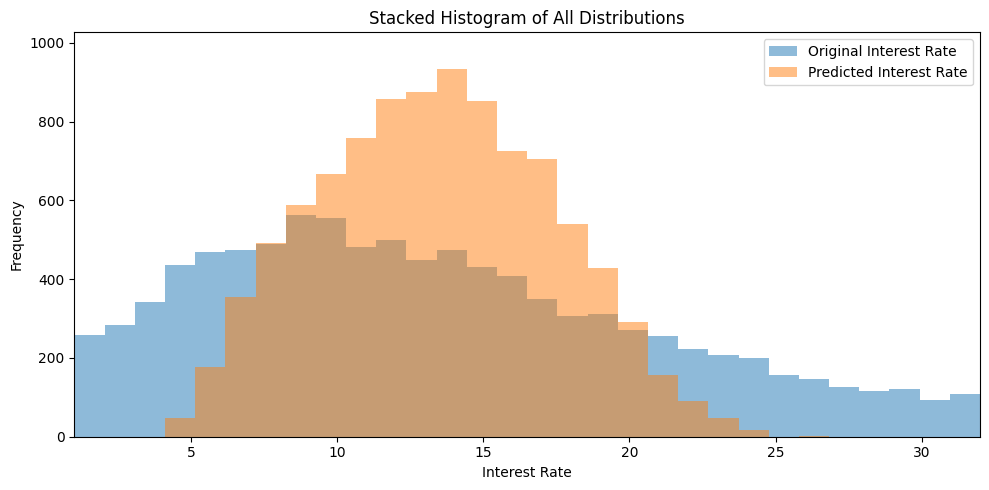

In [66]:
%matplotlib inline
y_pred = candidate_function(X)
plot_histograms([(y, 'Original Interest Rate', None), (y_pred, 'Predicted Interest Rate', None)], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

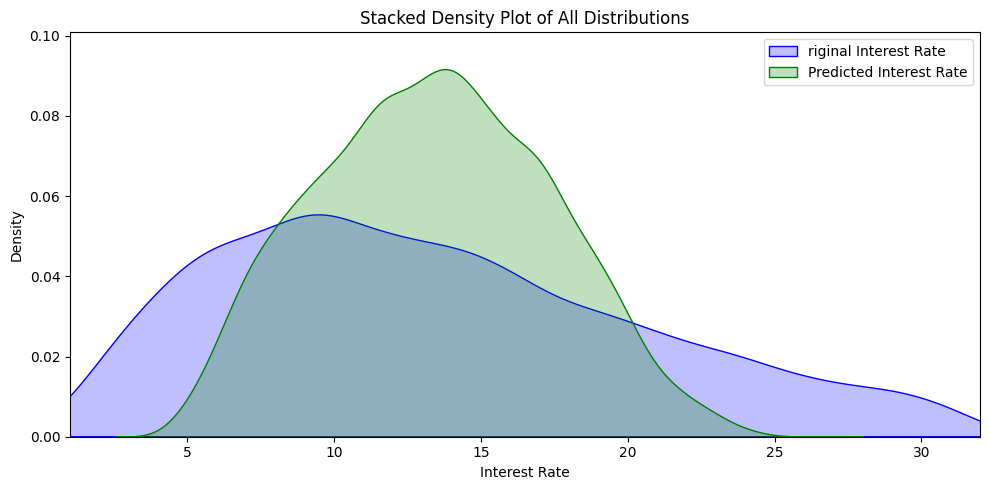

In [67]:
plot_densities([(y, 'riginal Interest Rate', 'blue'), (y_pred, 'Predicted Interest Rate', 'green')], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))

In [51]:
X_total = data_syn[['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts', 'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']].to_numpy()
y_total = data_syn['Interest_Rate'].to_numpy()

In [52]:
y_pred_total = candidate_function(X_total)

In [53]:
orig_residuals = y_total - y_pred_total

In [72]:
y_pred_total_corrected, best_amp, errors, _ = renoise_predictions(y_total, y_pred_total, method='stratified', seed=42, clip_lower=0, clip_upper=32, original_residuals=None, tail_replace=True, lower_percentile=50, upper_percentile=25)
# ignore error in orig_residuals after first run

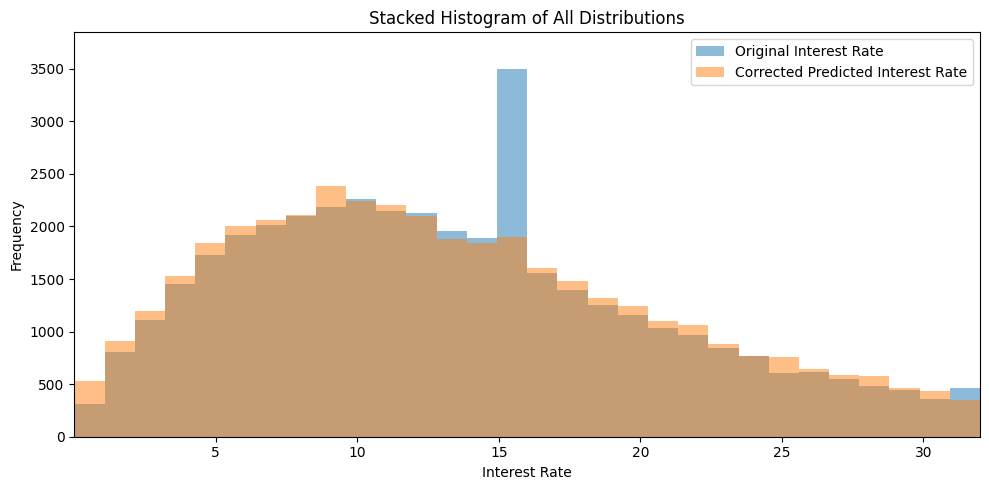

In [73]:
plot_histograms([(y_total, 'Original Interest Rate', None), (y_pred_total_corrected, 'Corrected Predicted Interest Rate', None)], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

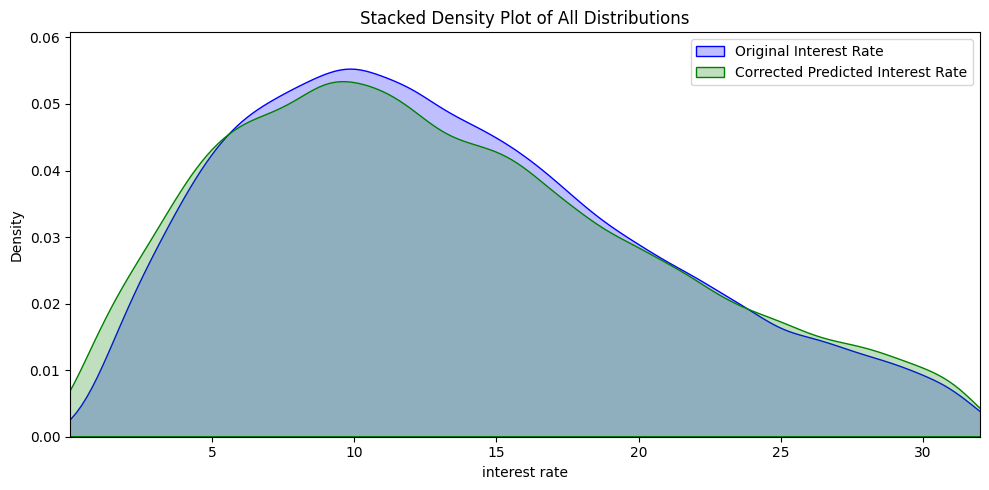

In [69]:
plot_densities([(y_total, 'Original Interest Rate', 'blue'), (y_pred_total_corrected, 'Corrected Predicted Interest Rate', 'green')], 'interest rate', stack=True, figsize_per_plot=(10, 5))

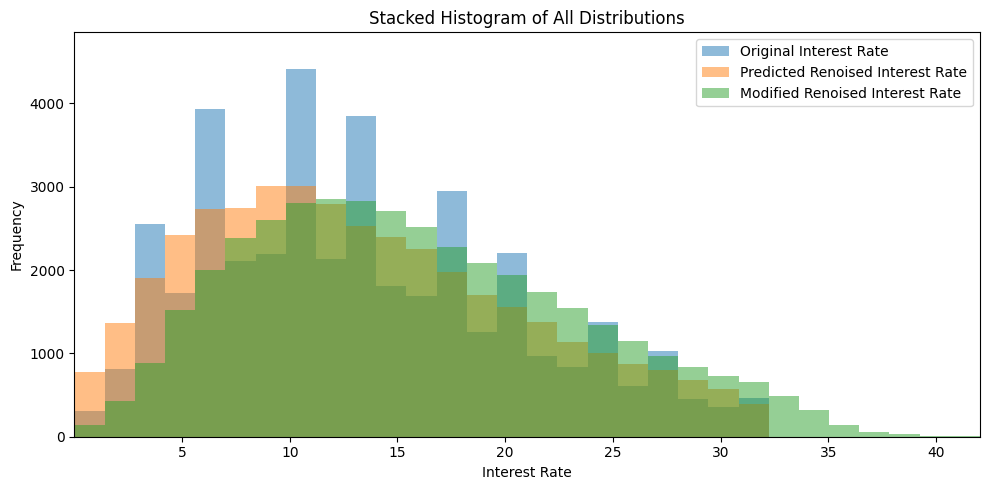

In [80]:
mod_candidate_function = generate_candidate_function("sqrt((abs((1*x1 - 1*x0) + sqrt(x5 * x3)) + (x4 * 2*x2)) + 19.390306)")
mod_y_pred_total = mod_candidate_function(X_total)
mod_y_pred_total_corrected, best_amp, errors, _ = renoise_predictions(y_total, mod_y_pred_total, method='stratified', amplification_factor=1.0, seed=42, clip_lower=0, clip_upper=None, original_residuals=orig_residuals, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run
plot_histograms([(y_total, 'Original Interest Rate', None), (y_pred_total_corrected, 'Predicted Renoised Interest Rate', None), (mod_y_pred_total_corrected, 'Modified Renoised Interest Rate', None)], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))